# 04 ROC AUC

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [50]:
data = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv"

In [53]:
df = pd.read_csv(data)

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [56]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [57]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [58]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [60]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)

accuracy = (y_val == churn_decision).mean()
print(f'Accuracy: {accuracy:.3f}')


Accuracy: 0.806


In [61]:
# calculate precision and recall

cm = confusion_matrix(y_val, churn_decision)
TN, FP, FN, TP = cm.ravel()
precision = TP / (TP + FP)
recall = TP / (TP + FN)
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')


Precision: 0.679
Recall: 0.549


### TPR, FPR

In [62]:
# calc tpr and fpr

tpr = TP / (TP + FN)
fpr = FP / (FP + TN)    

print(f'TPR: {tpr:.3f}')
print(f'FPR: {fpr:.3f}')    


TPR: 0.549
FPR: 0.098


tpr (Recall), ability to detect actual frauds, higher is better (near 1). 

fpr, tendency to raise false alarms, lower is better (near 0).

In example above, tpr = 0.549 and fpr 0.098

tpr 54.9%, it can be said the model can capture churn at 54.9%, around 45% is missed (false negative, predict as not churn but actually it's churn).

fpr 9.8%, it can be said the model will generate false alarm (false positive, predict as churn but actually it's not churn).

Ideally, the model should give tpr near to 1 and fpr near to 0.


### ROC (Receiver Operating Characteristic)

ROC is used to evaluate how well a model can separate positive and negative classes , for example, fraud vs not fraud.

ROC is built using two key metrics: tpr and fpr.
* tpr = TP / (TP + FN)
* fpr = FP / (FP + TN)  

To plot roc:
* Take model predictions as soft probabilities (values between 0 and 1).
* Convert probalilities to hard classification by settting a threshold.
* Vary the threshold from 0 to 1, for example [0, 0.1, 0.2, ... 0.8, 0.9, 1].
* For each threshold, compute TPR and FPR.
* There are two option to plot ROC:
  * Plot the points with: X-axis threshold, Y-axis TPR & FPR. This plot use to show how the TPR and FPR change with chaning threshold.
  * Pot with X-axis FPR and Y-axis TPR. If the curse is far from diagonal line, it means it's better.


Interpreting the ROC Curve:
* X-axis: FPR
* Y-axis: TPR
* Diagonal line (y = x): random guessing (AUC = 0.5)
* Curve bows toward top-left: better model, high TPR, low FPR.
* AUC (Area Under Curve): summarizes overall performance (closer to 1 = better). AUC = 0.5 model doesn't ability to do.

In [ ]:
scores = []


# set thresholds from 0 to 1 with step 0.01
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    # calculate tpr and fpr
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    scores.append((t, tp, fp, fn, tn, tpr, fpr))

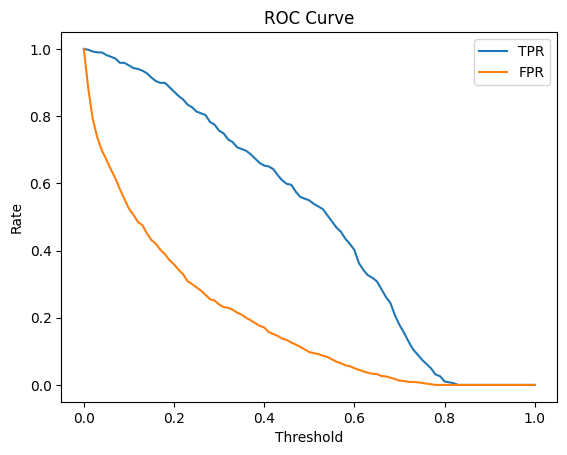

In [73]:
# convert to DataFrame
df_scores = pd.DataFrame(
    scores,
    columns=['threshold', 'tp', 'fp', 'fn', 'tn', 'tpr', 'fpr']
)

# plot ROC curve
plt.plot(df_scores['threshold'], df_scores['tpr'])
plt.plot(df_scores['threshold'], df_scores['fpr'])
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.legend(['TPR', 'FPR'])
plt.title('ROC Curve')
plt.show()


* When threshold = 0, everything is predicted as positive (1). The FPR = 1, it means many false alarm.
* When threshold = 1, everything is predicted as negative (0). The TPR = 0, it means model can't capture the churn.
* The ideal position is FPR as lower possible and TPR as higher possible. Threshold can be choose between 0.2-0.6



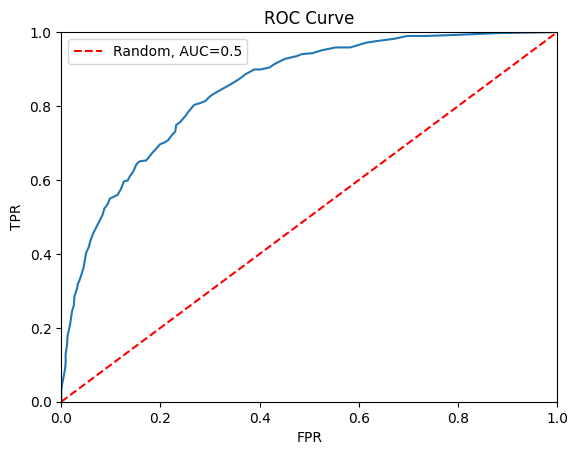

In [79]:
plt.plot(df_scores['fpr'], df_scores['tpr'])
plt.plot([0, 1], [0, 1], 'r--', label='Random, AUC=0.5')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.show()


By plotting fpr and tpr together in x-axis & y-axis, we can easily see the trade-off between false positives and true positives. 
The ideal point on the ROC curve is at the top-left corner (FPR = 0, TPR = 1), meaning no false positives and all true positives detected. However, this ideal condition is rarely achievable in real-world models. 
In practice, we must choose a threshold that balances both goals, keeping FPR as low as possible while maintaining TPR as high as possible, depending on the business or risk requirements.

If the ROC curve lies close to the diagonal line, it indicates that the model performs no better than random guessing.

### AUC (Area Under Curve)

It summarizes how well the model can separate positive and negative classes using a single number between 0 and 1.
AUC is a single number. It different from ROC, it a graph plot of tpr vs fpr.
AUC is like final summary with value let say x. If the value near 1, example 0.85, we can assume the model is better.
To calculate auc, we can use function roc_auc_score from sklearn.


In [82]:
auc = roc_auc_score(y_val, y_pred)
print(f'ROC AUC: {auc:.3f}')

ROC AUC: 0.847


In [ ]:
# how auc is calculated manually
# example with 10 samples

# y = [1 0 0 1 0 0 1 0 1 1]
# x = [65782. 68293. 56746. 52409. 58164. 61242. 62672. 63391. 62630. 82306.]

# separate x into two groups based on y, y=1 -> x1, y=0 -> x0
# then count how many times a value from x1 is greater than a value from x0
# finally divide that count by (number of y=1 * number of y=0)

# number of y=1 is 5
# number of y=0 is 5

x0 = [68293., 56746., 58164., 61242., 63391.]  # filter x only y=0
x1 = [65782., 52409., 62672., 62630., 82306.]  # filter x only y=1
p = 0
for v0 in x0:
    for v1 in x1:  # y=1
        if v1 > v0:
            p += 1

print(p)
auc = p / 25
print(auc)
